In [8]:
    import abc, jsonschema, rdflib, collections, copy, pyld.jsonld as jsonld, pandas
    import strict_rfc3339, rfc3986, rfc3987, IPython

In [9]:
    class JsonSchemaMeta(abc.ABCMeta):
        schema = None
        def __init_subclass__(cls, **kwargs): 
            jsonschema.validate(kwargs, cls.schema or {}, format_checker=jsonschema.FormatChecker())
            cls.schema = kwargs

    class JsonSchema(JsonSchemaMeta, **jsonschema.Draft7Validator.META_SCHEMA): 
        def __new__(cls, object=None, *args, **kwargs):
            object= super().__new__(cls, object, *args, **kwargs)
            jsonschema.validate(object.schema, cls.schema, format_checker=jsonschema.FormatChecker())
            return object

    class Type(metaclass=JsonSchema): 
        type = rdflib.namespace.XSD.type
        schema = {}
        def __new__(cls, object=None, *args, **kwargs):
            schema = cls.class_schema()
            if object is None: object = copy.copy(schema.get('default'))
            return jsonschema.validate(object, schema, format_checker=jsonschema.FormatChecker()) or super().__new__(cls, object, *args, **kwargs)

        def __init_subclass__(cls, **kwargs): cls.schema = kwargs
            
        @classmethod
        def class_schema(cls): return {**collections.ChainMap(*(getattr(object, 'schema', {}) or {} for object in cls.__mro__)), 'title': cls.__name__, }
        @classmethod
        def class_context(cls): return {**collections.ChainMap(*(getattr(object, 'schema', {}).get('@context', {}) or {} for object in cls.__mro__))}
        
        @classmethod
        def object(type, object=None):
            for cls in (type.__subclasses__()):
                try: return cls.object(object)
                except BaseException as e: ...
            else: return type(object)
        
        def expand(self, context=None): 
            context = {**self.class_context(), **(context or {})}
            return jsonld.expand({self.type: self, **{x: getattr(self, x) for x in context if hasattr(self, 'x')}}, options=dict(expandContext=context))


In [10]:
    class Literal(Type):
        def _repr_json_(self): return self.expand(), {'expanded': True, 'root': type(self).__name__}
        
    class Null(Literal, type='null'): 
        def __new__(cls, object=None, *args, **kwargs): return jsonschema.validate(object, cls.class_schema(), format_checker=jsonschema.FormatChecker())

    class String(Literal, str, type='string', default=''): type = rdflib.namespace.XSD.string
    class Number(Literal, float, type='number', default=''): type = rdflib.namespace.XSD.decimal
    class Integer(Literal, int, type='integer', default=''): type = rdflib.namespace.XSD.integer

In [11]:
    class Container(Literal): 
        def _repr_json_(self): return self, {'expanded': True, 'root': type(self).__name__, '@graph': self.expand()}
    class List(Container, list, type='array', default=[]): ...
    class Dict(Container, dict, type='object', default={}): ...

In [12]:
    class Email(String, format='email'): type = rdflib.namespace.XSD.email
    class Uri(String, format='uri'): ...
    class Pointer(Uri, format='json-pointer'): ...
    class Date(String, format='date'): type = rdflib.namespace.XSD.date
    class Datetime(String, format='date-time'): type = rdflib.namespace.XSD.datetime
    class Time(String, format='time'): type = rdflib.namespace.XSD.time        

In [13]:
    class Describe(Type): 
        type = rdflib.namespace.XSD.type
        schema = {}
        def __new__(cls, object=None, *graph, **context):
            if isinstance(object, cls.__mro__[:-1]): 
                context = {**cls.class_context(), **(context or {})}
                graph = list(graph)+jsonld.expand({
                    x: list(getattr(object, x)) for x in context if hasattr(object, x) and getattr(object, x) is not None
                }, options=dict(expandContext=context))
                IPython.display.display(IPython.display.JSON(graph, root='@graph'), metadata={'@graph': graph})
                return object
            raise TypeError(F"{object} is not an instance of {cls.__mro__[:-1]}")

    class Display(Describe, IPython.display.DisplayObject, **{'@context': {'data': None, 'url': '@id', 'filename': {'@type': '@id', '@id': rdflib.namespace.RDF.type}, 'format': '://contentType'}}): ...
    class DataFrame(Describe, pandas.DataFrame, **{'@context': {'shape': '://dimension'}}): ...

In [14]:
    df = Describe.object(pandas.util.testing.makeDataFrame())

<IPython.core.display.JSON object>

<IPython.core.display.JSON object>

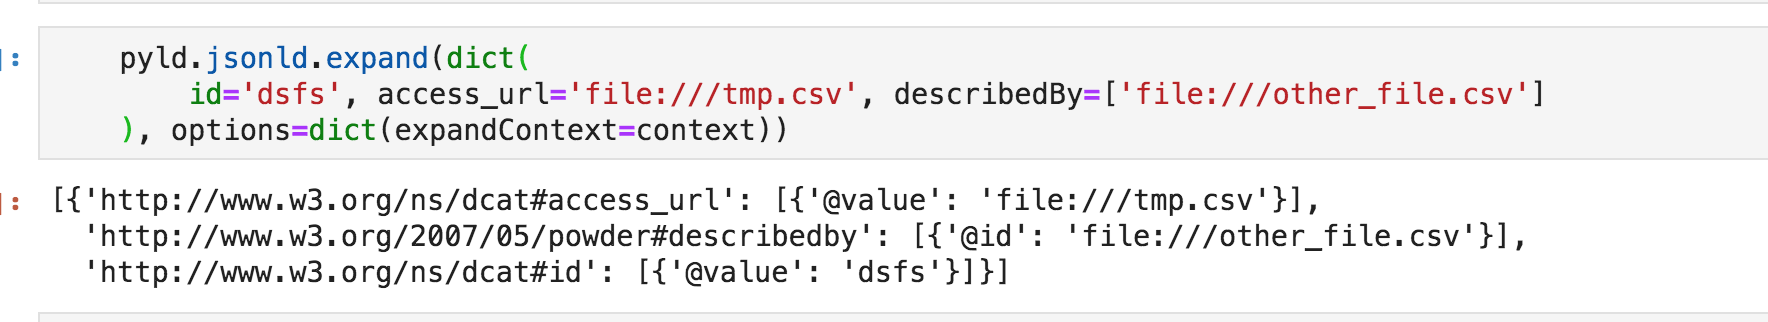

In [16]:
    Describe.object(IPython.display.Image(filename='Desktop/Screen Shot 2019-08-12 at 3.00.55 PM.png'))